Firstly, let's import all the data and libaries that we will need to use

In [4]:
import sys
import pickle
from pprint import pprint
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [5]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [6]:
# Define all the features

In [7]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi']

We will now do some explorations on the dataset, to see if there are any outliers or missing values.

In [8]:
# Basic Exploration
print "Total number of observations: {}".format(len(data_dict))
print "Total number of features: {}".format(len(financial_features) + len(email_features))
print "Total number of poi: {}".format(str(sum(1 for x in data_dict.values() if x['poi'])))

Total number of observations: 146
Total number of features: 20
Total number of poi: 18


And how many missing values?

In [9]:
# find out if any features are having extremely large number of missing values
for feature in financial_features:
    print "{}: {}".format(feature, str(sum(1 for x in data_dict.values() if x[feature] == 'NaN')))

for feature in email_features:
    print "{}: {}".format(feature, str(sum(1 for x in data_dict.values() if x[feature] == 'NaN')))

print "{}: {}".format('poi', str(sum(1 for x in data_dict.values() if x['poi'] == 'NaN')))

salary: 51
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
exercised_stock_options: 44
other: 53
long_term_incentive: 80
restricted_stock: 36
director_fees: 129
to_messages: 60
email_address: 35
from_poi_to_this_person: 60
from_messages: 60
from_this_person_to_poi: 60
shared_receipt_with_poi: 60
poi: 0


We would also like to find out people who have no data at all

In [10]:
# We would also want to find out if any observations are missing all values and see if they are poi
person_with_no_data = []
for person in data_dict.keys():
    number_of_missing_fields = sum(1 for x in data_dict[person].values() if x == 'NaN')
    if number_of_missing_fields >= 19:
        person_with_no_data.append(person)
    if number_of_missing_fields >= 15:
        print "Number of missing fields for {}: {}. is_poi? {}".format(person, number_of_missing_fields,
                                                                   data_dict[person]['poi'])
        
pprint(person_with_no_data)

# For those that doesn't have any value in it (all features are missing value), we will remove them
# as it doesn't make sense to consider them as a "record"
for person in person_with_no_data:
    del data_dict[person]

Number of missing fields for LOWRY CHARLES P: 16. is_poi? False
Number of missing fields for WALTERS GARETH W: 15. is_poi? False
Number of missing fields for CHAN RONNIE: 16. is_poi? False
Number of missing fields for WODRASKA JOHN: 17. is_poi? False
Number of missing fields for URQUHART JOHN A: 16. is_poi? False
Number of missing fields for WHALEY DAVID A: 18. is_poi? False
Number of missing fields for MENDELSOHN JOHN: 16. is_poi? False
Number of missing fields for CLINE KENNETH W: 17. is_poi? False
Number of missing fields for WAKEHAM JOHN: 17. is_poi? False
Number of missing fields for DUNCAN JOHN H: 15. is_poi? False
Number of missing fields for LEMAISTRE CHARLES: 15. is_poi? False
Number of missing fields for WROBEL BRUCE: 18. is_poi? False
Number of missing fields for MEYER JEROME J: 16. is_poi? False
Number of missing fields for SCRIMSHAW MATTHEW: 17. is_poi? False
Number of missing fields for GATHMANN WILLIAM D: 16. is_poi? False
Number of missing fields for GILLIS JOHN: 17. is

We found that records with high number of missing fields are usually not poi, so we will create a new feature of number_of_missing_fields

In [11]:
for person in data_dict.keys():
    data_dict[person]['number_of_missing_fields'] = sum(1 for x in data_dict[person].values() if x == 'NaN')

Also, email_address doesn't seem to be related in anyway for predicting if someone is poi or not

In [12]:
email_features.remove('email_address')

# Data Distributions

For easier investigations on the fields, let's convert them into pandas data frame first.

In [13]:
features_list = ['poi'] + financial_features + email_features
features_list_without_label = financial_features + email_features

df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()

df.drop('email_address', axis=1, inplace=True)

let's try to examine the all the names to see if there are anything weird

In [14]:
data_dict.keys()

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNCAN JOHN H'

After some examinations, there are two other weird entries that need to be removed, which are `TOTAL` and `TRAVEL AGENCY IN THE PARK`

In [15]:
del data_dict['TOTAL']
del data_dict['THE TRAVEL AGENCY IN THE PARK']

df.drop('TOTAL', inplace=True)
df.drop('THE TRAVEL AGENCY IN THE PARK', inplace=True)

In [16]:
for col in financial_features:
    df[col] = df[col].astype('float64')
    
for col in email_features:
    df[col] = df[col].astype('float64')


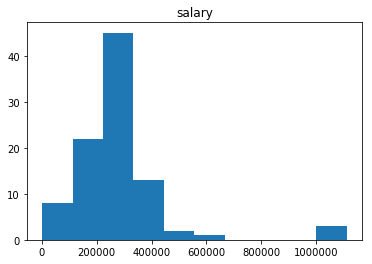

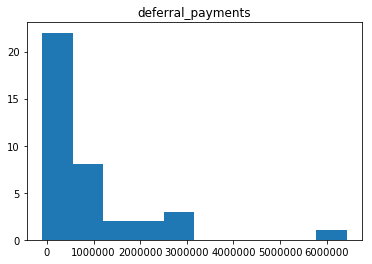

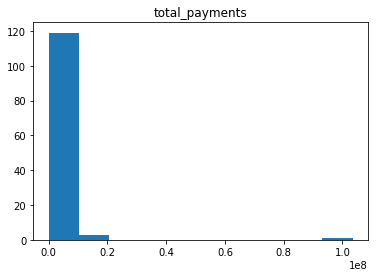

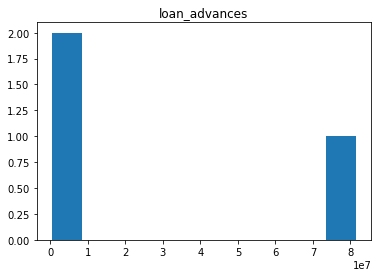

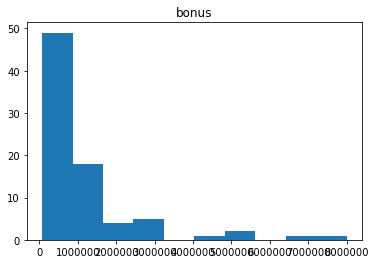

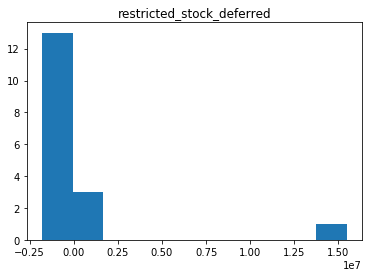

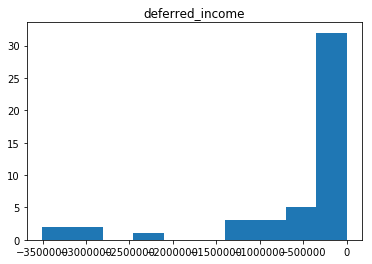

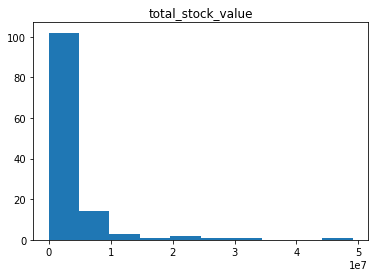

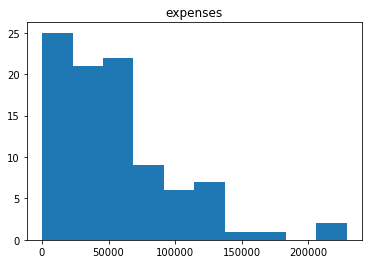

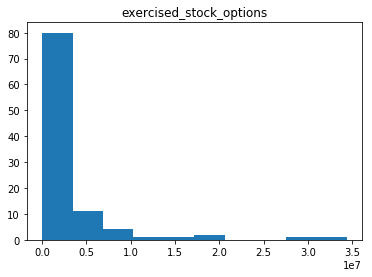

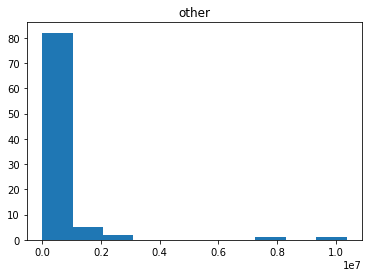

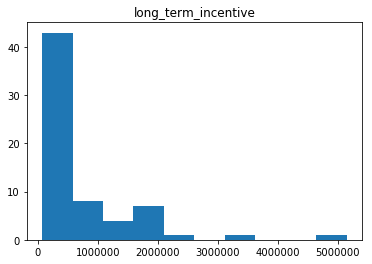

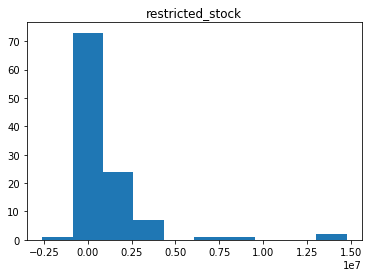

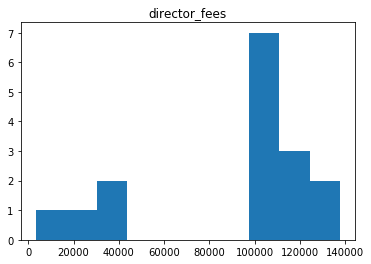

In [17]:
for idx, col in enumerate(financial_features):
    plt.figure(idx)
    plt.title(col)
    plt.hist(df[col].dropna())

There are a number of fields with outliers as we see in the histogram.
Extreme large values: salary, deferral_payments, total_payments, bonus, total_stock_value, expenses, exercised_stock_options, other, long_term_incentive, restricted_stock, director_fees, 
Extreme small values: deferred_income

So we will investigate these fields one by one

In [18]:
df.sort_values(by = 'salary', ascending=False)

,to_messages,deferral_payments,expenses,poi,number_of_missing_fields,deferred_income,long_term_incentive,restricted_stock_deferred,shared_receipt_with_poi,loan_advances,...,other,director_fees,bonus,total_stock_value,from_poi_to_this_person,from_this_person_to_poi,restricted_stock,salary,total_payments,exercised_stock_options
SKILLING JEFFREY K,3627.0,NaN,29336.0,True,5,NaN,1920000.0,NaN,2042.0,NaN,...,22122.0,NaN,5600000.0,26093672.0,88.0,30.0,6843672.0,1111258.0,8682716.0,19250000.0
LAY KENNETH L,4273.0,202911.0,99832.0,True,2,-300000.0,3600000.0,NaN,2411.0,81525000.0,...,10359729.0,NaN,7000000.0,49110078.0,123.0,16.0,14761694.0,1072321.0,103559793.0,34348384.0
FREVERT MARK A,3275.0,6426990.0,86987.0,False,2,-3367011.0,1617011.0,NaN,2979.0,2000000.0,...,7427621.0,NaN,2000000.0,14622185.0,242.0,6.0,4188667.0,1060932.0,17252530.0,10433518.0
PICKERING MARK R,898.0,NaN,31653.0,False,7,NaN,NaN,NaN,728.0,400000.0,...,NaN,NaN,300000.0,28798.0,7.0,0.0,NaN,655037.0,1386690.0,28798.0
WHALLEY LAWRENCE G,6019.0,NaN,57838.0,False,5,NaN,808346.0,NaN,3920.0,NaN,...,301026.0,NaN,3000000.0,6079137.0,186.0,24.0,2796177.0,510364.0,4677574.0,3282960.0
DERRICK JR. JAMES V,2181.0,NaN,51124.0,False,3,-1284000.0,484000.0,-1787380.0,1401.0,NaN,...,7482.0,NaN,800000.0,8831913.0,64.0,20.0,1787380.0,492375.0,550981.0,8831913.0
FASTOW ANDREW S,NaN,NaN,55921.0,True,10,-1386055.0,1736055.0,NaN,NaN,NaN,...,277464.0,NaN,1300000.0,1794412.0,NaN,NaN,1794412.0,440698.0,2424083.0,NaN
SHERRIFF JOHN R,3187.0,NaN,NaN,False,6,NaN,554422.0,NaN,2103.0,NaN,...,1852186.0,NaN,1500000.0,3128982.0,28.0,23.0,1293424.0,428780.0,4335388.0,1835558.0
RICE KENNETH D,905.0,NaN,46950.0,True,4,-3504386.0,1617011.0,NaN,864.0,NaN,...,174839.0,NaN,1750000.0,22542539.0,42.0,4.0,2748364.0,420636.0,505050.0,19794175.0
CAUSEY RICHARD A,1892.0,NaN,30674.0,True,5,-235000.0,350000.0,NaN,1585.0,NaN,...,307895.0,NaN,1000000.0,2502063.0,58.0,12.0,2502063.0,415189.0,1868758.0,NaN


We can obviously see that the first record is having an outlier value of salary, let's remove `SKILLING JEFFREY K` and plot the histograms again

In [19]:
del data_dict['SKILLING JEFFREY K']

df.drop('SKILLING JEFFREY K', inplace=True)

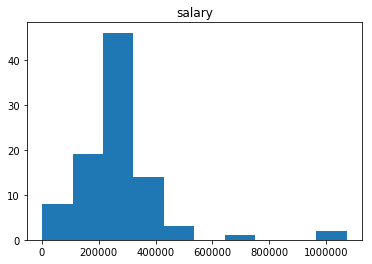

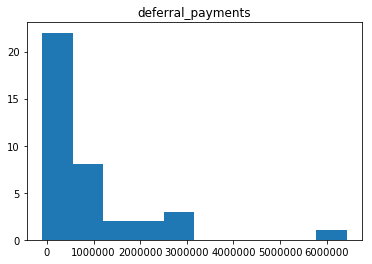

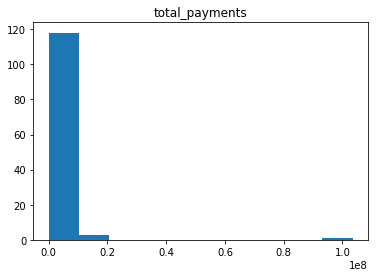

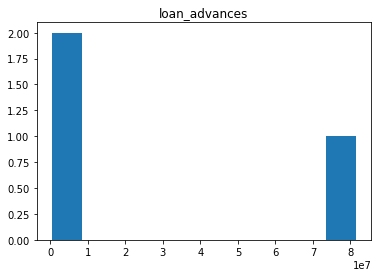

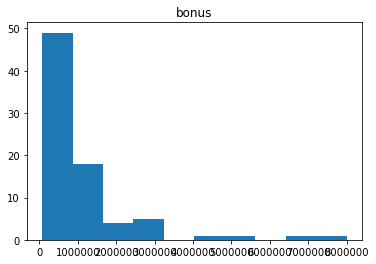

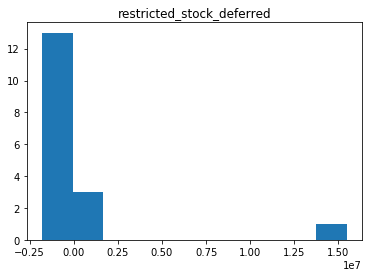

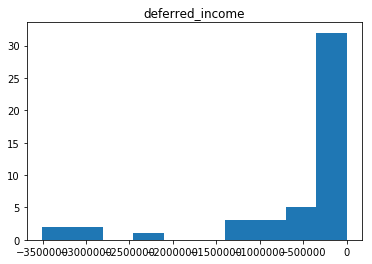

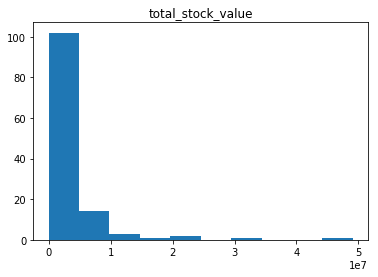

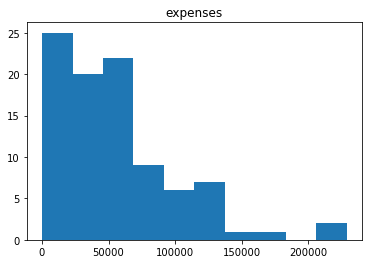

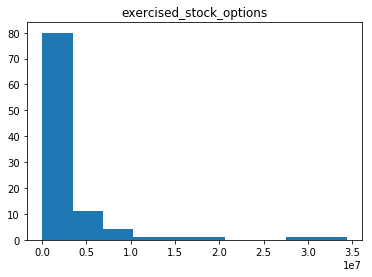

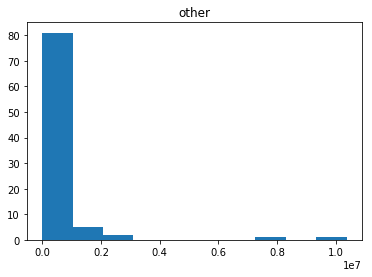

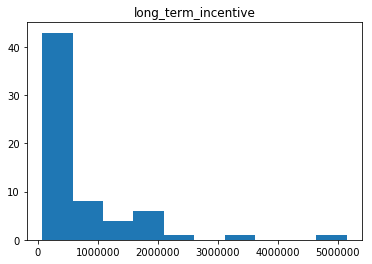

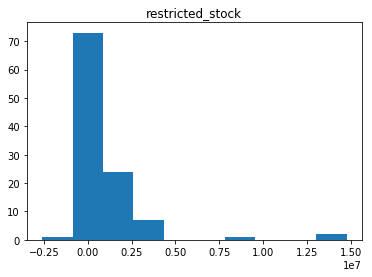

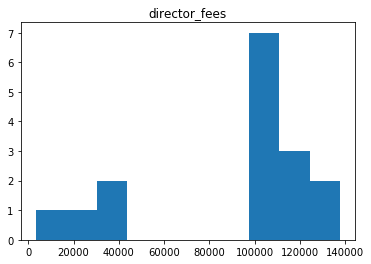

In [20]:
for idx, col in enumerate(financial_features):
    plt.figure(idx)
    plt.title(col)
    plt.hist(df[col].dropna())

There are still extreme values in total_payments

In [21]:
df.sort_values(by = 'total_payments', ascending=False)

,to_messages,deferral_payments,expenses,poi,number_of_missing_fields,deferred_income,long_term_incentive,restricted_stock_deferred,shared_receipt_with_poi,loan_advances,...,other,director_fees,bonus,total_stock_value,from_poi_to_this_person,from_this_person_to_poi,restricted_stock,salary,total_payments,exercised_stock_options
LAY KENNETH L,4273.0,202911.0,99832.0,True,2,-300000.0,3600000.0,NaN,2411.0,81525000.0,...,10359729.0,NaN,7000000.0,49110078.0,123.0,16.0,14761694.0,1072321.0,103559793.0,34348384.0
FREVERT MARK A,3275.0,6426990.0,86987.0,False,2,-3367011.0,1617011.0,NaN,2979.0,2000000.0,...,7427621.0,NaN,2000000.0,14622185.0,242.0,6.0,4188667.0,1060932.0,17252530.0,10433518.0
BHATNAGAR SANJAY,523.0,NaN,NaN,False,8,NaN,NaN,15456290.0,463.0,NaN,...,137864.0,137864.0,NaN,NaN,0.0,1.0,-2604490.0,NaN,15456290.0,2604490.0
LAVORATO JOHN J,7259.0,NaN,49537.0,False,5,NaN,2035380.0,NaN,3962.0,NaN,...,1552.0,NaN,8000000.0,5167144.0,528.0,411.0,1008149.0,339288.0,10425757.0,4158995.0
MARTIN AMANDA K,1522.0,85430.0,8211.0,False,6,NaN,5145434.0,NaN,477.0,NaN,...,2818454.0,NaN,NaN,2070306.0,8.0,0.0,NaN,349487.0,8407016.0,2070306.0
BAXTER JOHN C,NaN,1295738.0,11200.0,False,9,-1386055.0,1586055.0,NaN,NaN,NaN,...,2660303.0,NaN,1200000.0,10623258.0,NaN,NaN,3942714.0,267102.0,5634343.0,6680544.0
BELDEN TIMOTHY N,7991.0,2144013.0,17355.0,True,4,-2334434.0,NaN,NaN,5521.0,NaN,...,210698.0,NaN,5249999.0,1110705.0,228.0,108.0,157569.0,213999.0,5501630.0,953136.0
DELAINEY DAVID W,3093.0,NaN,86174.0,True,5,NaN,1294981.0,NaN,2097.0,NaN,...,1661.0,NaN,3000000.0,3614261.0,66.0,609.0,1323148.0,365163.0,4747979.0,2291113.0
WHALLEY LAWRENCE G,6019.0,NaN,57838.0,False,5,NaN,808346.0,NaN,3920.0,NaN,...,301026.0,NaN,3000000.0,6079137.0,186.0,24.0,2796177.0,510364.0,4677574.0,3282960.0
ALLEN PHILLIP K,2902.0,2869717.0,13868.0,False,2,-3081055.0,304805.0,-126027.0,1407.0,NaN,...,152.0,NaN,4175000.0,1729541.0,47.0,65.0,126027.0,201955.0,4484442.0,1729541.0


Let remove `LAY KENNETH L` and plot the instagram again

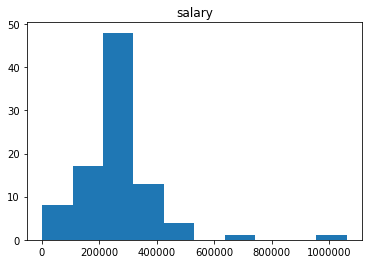

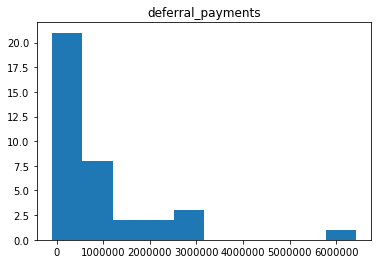

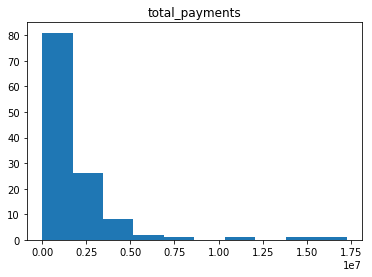

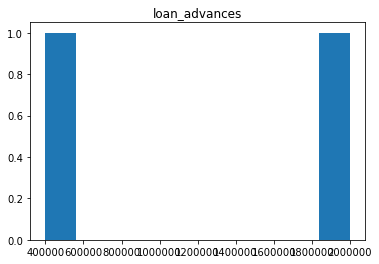

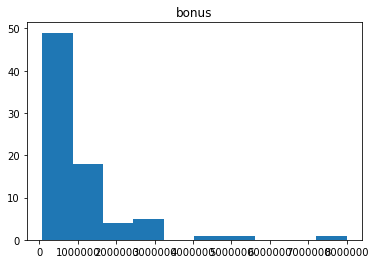

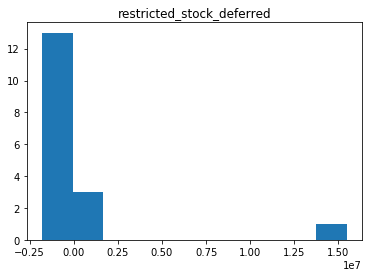

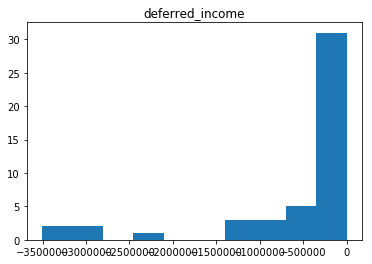

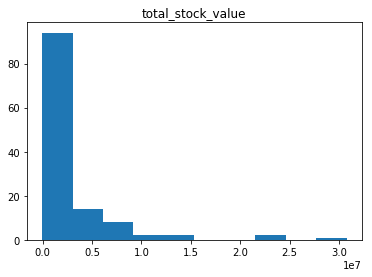

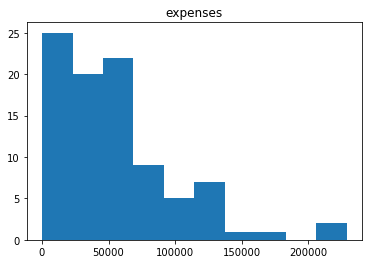

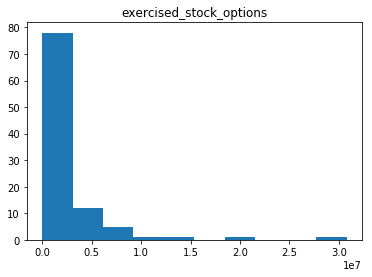

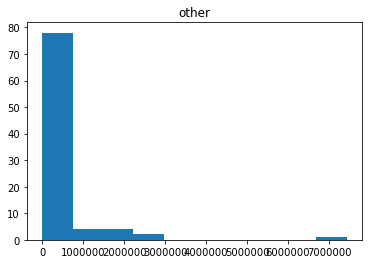

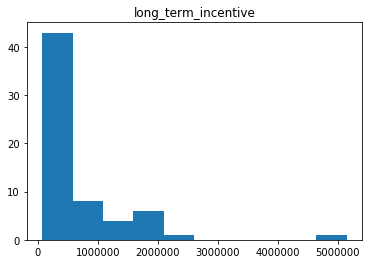

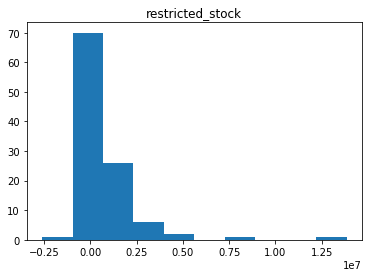

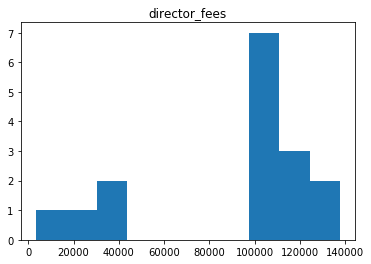

In [22]:
del data_dict['LAY KENNETH L']

df.drop('LAY KENNETH L', inplace=True)

for idx, col in enumerate(financial_features):
    plt.figure(idx)
    plt.title(col)
    plt.hist(df[col].dropna())

Seems all the outliers are now removed. Now quickly check on the distribution of the poi

In [23]:
print "Total number of poi: {}".format(str(sum(1 for x in data_dict.values() if x['poi'])))

Total number of poi: 16


And do feature scaling before we proceed

In [24]:
# convert the fields we want into numbers
for person in data_dict:
    for feature in ['salary']:
        if data_dict[person][feature] == "NaN":
            data_dict[person][feature] = 0
        else:
            data_dict[person][feature] = float(data_dict[person][feature])

# feature scaling
for feature in ['salary']:
    feature_max = max(x[feature] for x in data_dict.values())
    feature_min = min(x[feature] for x in data_dict.values())
    
    for person in data_dict:
        data_dict[person][feature] = (data_dict[person][feature] - feature_min) / (feature_max - feature_min)

And prepare for the data format that sklearn will use

In [25]:
### Extract features and labels from dataset for local testing
my_dataset = data_dict
features_list = ['poi'] + financial_features + email_features + ['number_of_missing_fields']
data = featureFormat(my_dataset, features_list, sort_keys=False)
labels, features = targetFeatureSplit(data)

As we are not sure if our features are independent to each other, SelectKBest might not be suitable in our case. So we will use Feature Importance to decide the features to use.

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

actual_features = financial_features + email_features + ['number_of_missing_fields']

clf = ExtraTreesClassifier()
clf = clf.fit(features, labels)
print clf.feature_importances_  

df = pd.DataFrame({'features':actual_features, 'score':clf.feature_importances_})
df.sort_values(by = 'score', ascending=False)


[ 0.04063701  0.020343    0.05430746  0.          0.09077891  0.00752371
  0.07564031  0.09578195  0.06873223  0.07891142  0.08392757  0.05563517
  0.06996962  0.00150117  0.02293117  0.05393357  0.02657227  0.06513205
  0.04419486  0.04354655]


,features,score
7,total_stock_value,0.095782
4,bonus,0.090779
10,other,0.083928
9,exercised_stock_options,0.078911
6,deferred_income,0.075640
12,restricted_stock,0.069970
8,expenses,0.068732
17,from_this_person_to_poi,0.065132
11,long_term_incentive,0.055635
2,total_payments,0.054307


As we are not sure how many factors to pick, we will try with different combinations, starting from only one feature. We will plot the precision and recall score to compare on the performance

In [27]:
As this scoring is probabilistic, so we will mark it down here to prevent it keep changing

SyntaxError: invalid syntax (<ipython-input-27-90b558a47242>, line 1)

In [28]:
sorted_features = [
    'total_stock_value',
    'exercised_stock_options',
    'deferred_income',
    'from_this_person_to_poi',
    'restricted_stock',
    'other',
    'long_term_incentive',
    'total_payments',
    'number_of_missing_fields',
    'salary',
    'bonus',
    'shared_receipt_with_poi',
    'expenses',
    'from_messages',
    'from_poi_to_this_person',
    'to_messages',
    'deferral_payments',
    'restricted_stock_deferred',
    'director_fees',
    'loan_advances'
]

We will use svm for test first, to see what are the variation on the performance.

([<matplotlib.axis.XTick at 0x1182870d0>,
 <a list of 22 Text xticklabel objects>)

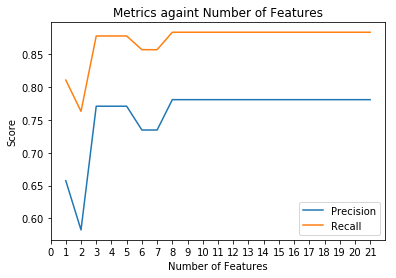

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.cross_validation import train_test_split
from matplotlib.pyplot import xticks

precision_scores = []
accuracy_scores = []
recall_scores = []

for i in range(21):
    features_list = ['poi'] + sorted_features[0: i+1]
    data = featureFormat(my_dataset, features_list, sort_keys=False)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
       
    svm_clf = SVC()
    svm_clf.fit(features_train, labels_train)
    accuracy_scores.append(svm_clf.score(features_test, labels_test))
    precision_scores.append(precision_score(labels_test, svm_clf.predict(features_test), average='weighted'))
    recall_scores.append(recall_score(labels_test, svm_clf.predict(features_test), average='weighted'))
    
plt.figure(1)
plt.plot(range(1, 22, 1), precision_scores, label='Precision')
plt.plot(range(1, 22, 1), recall_scores, label='Recall')
plt.title('Metrics againt Number of Features')
plt.ylabel('Score')
plt.xlabel('Number of Features')
plt.legend()
plt.xticks(range(22))

Next, we will try decision tree

([<matplotlib.axis.XTick at 0x118dbb0d0>,
 <a list of 22 Text xticklabel objects>)

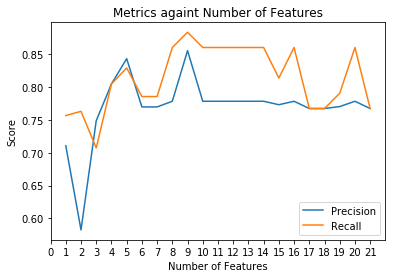

In [34]:
from sklearn import tree

precision_scores = []
accuracy_scores = []
recall_scores = []

for i in range(21):
    features_list = ['poi'] + sorted_features[0: i+1]
    data = featureFormat(my_dataset, features_list, sort_keys=False)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
       
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf.fit(features_train, labels_train)
    accuracy_scores.append(tree_clf.score(features_test, labels_test))
    precision_scores.append(precision_score(labels_test, tree_clf.predict(features_test), average='weighted'))
    recall_scores.append(recall_score(labels_test, tree_clf.predict(features_test), average='weighted'))
    
plt.figure(1)
plt.plot(range(1, 22, 1), precision_scores, label='Precision')
plt.plot(range(1, 22, 1), recall_scores, label='Recall')
plt.title('Metrics againt Number of Features')
plt.ylabel('Score')
plt.xlabel('Number of Features')
plt.legend()
plt.xticks(range(22))

In [ ]:
And lastly testing on GaussianNB

([<matplotlib.axis.XTick at 0x1179b0490>,
 <a list of 22 Text xticklabel objects>)

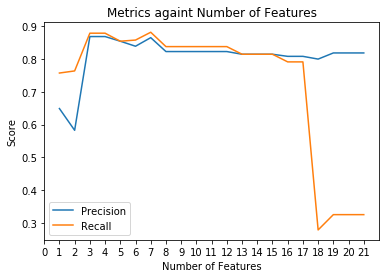

In [36]:
from sklearn.naive_bayes import GaussianNB

precision_scores = []
accuracy_scores = []
recall_scores = []

for i in range(21):
    features_list = ['poi'] + sorted_features[0: i+1]
    data = featureFormat(my_dataset, features_list, sort_keys=False)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
       
    gaussian_clf = GaussianNB()
    gaussian_clf.fit(features_train, labels_train)
    accuracy_scores.append(gaussian_clf.score(features_test, labels_test))
    precision_scores.append(precision_score(labels_test, gaussian_clf.predict(features_test), average='weighted'))
    recall_scores.append(recall_score(labels_test, gaussian_clf.predict(features_test), average='weighted'))
    
plt.figure(1)
plt.plot(range(1, 22, 1), precision_scores, label='Precision')
plt.plot(range(1, 22, 1), recall_scores, label='Recall')
plt.title('Metrics againt Number of Features')
plt.ylabel('Score')
plt.xlabel('Number of Features')
plt.legend()
plt.xticks(range(22))

Balancing the above 3 charts, seems 9 features would be the optimal number for SVM and decision tree. and 3 features is optimal for Gaussian-Bayes. And now update the features_list

In [158]:
features_list = ['poi'] + sorted_features[0: 9]
print features_list

['poi', 'total_stock_value', 'exercised_stock_options', 'deferred_income', 'from_this_person_to_poi', 'restricted_stock', 'other', 'long_term_incentive', 'total_payments', 'number_of_missing_fields']


Now we will need to choose the best setting for SVM and decision tree. (Gaussian Tree doesn't need to be tune)

In [ ]:
from sklearn import model_selection

# for svm
parameters = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': np.arange(1000, 100000, 1000)}
svr = SVC()
clf = model_selection.GridSearchCV(svr, parameters, scoring='precision', n_jobs=2, verbose=1)
clf.fit(features_train, labels_train)
print clf.best_params_
print clf.best_score_


# for decision tree
parameters = {
    'criterion': ('gini', 'entropy'),
    'splitter': ('best', 'random'),
    'max_features': np.arange(1, 5, 1),
    'max_depth': np.arange(1, 10, 1),
    'min_samples_split': np.arange(2, 40, 1),
}

tree = tree.DecisionTreeClassifier()
clf = model_selection.GridSearchCV(tree, parameters, scoring='precision', n_jobs=2, verbose=1)
clf.fit(features_train, labels_train)
print clf.best_params_
print clf.best_score_

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


Let's try to use GridSearchCV to tune the parameter of svm and decision tree. (No parameter tuning is needed for Gaussian-Bayes)

After going through similar GridSearchCV process as above, we found that for these 3 features, the best setup:

__For Decision tree__

`{'max_features': 4, 'min_samples_split': 30, 'criterion': 'gini', 'max_depth': 2, 'splitter': 'random'}`

__For SVM__

`{'kernel': 'poly', 'C': 17000}`

And the metrics:

__For Decision tree (with 9 features)__

Precision: 0.23077

Recall: 0.01800

__For SVM (with 9 features)__

Precision: 0.39577

Recall: 0.12150

__For Gaussian Classifier(with 3 features)__

Precision: 0.46259

Recall: 0.32150

After all the testing, Gaussian Classifier with 3 features(`total_stock_value`, `exercised_stock_options`, `deferred_income`) actually outperform SVM or decision tree under their best setup. 